In [ ]:
import numpy as np
!pip install xgboost optuna


In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split


# Step 1: Upload the file
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

# Step 2: Drop non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=["number"]).columns.tolist()
df_numeric = df.drop(columns=non_numeric_cols)

# Step 3: Define features and target
X = df_numeric.drop("Label", axis=1)
y = df_numeric["Label"]

# Step 4: Split data → 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
# This gives: 60% train, 20% val, 20% test

# Step 5: Scale features (fit only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)



Saving DIA_testset_RDKit_descriptors.csv to DIA_testset_RDKit_descriptors (1).csv
Saving DIA_trainingset_RDKit_descriptors.csv to DIA_trainingset_RDKit_descriptors (1).csv


In [ ]:
print("Training set:", X_train_scaled.shape, y_train.shape)
print("Validation set:", X_val_scaled.shape, y_val.shape)
print("Test set:", X_test_scaled.shape, y_test.shape)


Training set: (72, 196) (72,)
Validation set: (24, 196) (24,)
Test set: (24, 196) (24,)


In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.1 MB/s eta 0:00:00


In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb

#get the ratio of classes to set scale_pos_weight
neg_count = sum(y_train_resampled == 0)
pos_count = sum(y_train_resampled == 1)
scale_pos_weight = neg_count / pos_count

# Define objective with 5-fold CV
def objective(trial):
    # Suggest hyperparameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "use_label_encoder": False,
        "eval_metric": "auc"
    }

    # Initialize model
    model = xgb.XGBClassifier(**param)

    # Set up Stratified 5-Fold CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, valid_idx in skf.split(X_train_resampled, y_train_resampled):
        X_train_fold = X_train_resampled[train_idx]
        y_train_fold = y_train_resampled[train_idx]
        X_valid_fold = X_train_resampled[valid_idx]
        y_valid_fold = y_train_resampled[valid_idx]

        model.fit(X_train_fold, y_train_fold)

        y_valid_pred = model.predict_proba(X_valid_fold)[:, 1]
        auc = roc_auc_score(y_valid_fold, y_valid_pred)
        auc_scores.append(auc)

    # Return mean AUC across folds
    return np.mean(auc_scores)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Print best result
print("Best Hyperparameters:", study.best_params)
print("Best Mean CV AUC:", study.best_value)

# Retrain final model with best params
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "use_label_encoder": False,
    "verbosity": 0,
    "eval_metric": "auc"
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

X_test_preds = final_model.predict_proba(X_test_scaled)[:, 1]
X_test_pred_labels = final_model.predict(X_test_scaled)

print("\n=== Final Model Performance on Test Set ===")
print("Accuracy:", accuracy_score(y_test, X_test_pred_labels))
print("AUC Score:", roc_auc_score(y_test, X_test_preds))
print("\nClassification Report:\n", classification_report(y_test, X_test_pred_labels))

[I 2025-06-11 10:17:30,881] A new study created in memory with name: no-name-ff17c4b2-30c7-4f0d-b6eb-a7d4605050a4
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[10:17:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[10:17:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[10:17:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[10:17:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[10:17:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not

Best Hyperparameters: {'n_estimators': 951, 'max_depth': 10, 'learning_rate': 0.23297509057723623, 'subsample': 0.8108976916777256, 'colsample_bytree': 0.6305171768375044, 'gamma': 0.40922452752548455, 'min_child_weight': 1}
Best Mean CV AUC: 0.988099173553719

=== Final Model Performance on Test Set ===
Accuracy: 0.7916666666666666
AUC Score: 0.5833333333333334

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.67      0.33      0.44         6

    accuracy                           0.79        24
   macro avg       0.74      0.64      0.66        24
weighted avg       0.77      0.79      0.76        24



In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
        "eval_metric": "auc",
        "use_label_encoder": False,
        "random_state": 42
    }

    model = XGBClassifier(**params)
    model.fit(X_train_scaled, y_train)
    preds = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, preds)
    return auc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best AUC:", study.best_value)
print("Best Parameters:", study.best_params)



[I 2025-06-11 09:36:54,217] A new study created in memory with name: no-name-e1728698-52a8-47ce-a53f-040b231a017e
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:36:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-11 09:36:55,020] Trial 0 finished with value: 0.5462962962962963 and parameters: {'max_depth': 3, 'learning_rate': 0.11863424422773003, 'n_estimators': 95, 'subsample': 0.9272676497539567, 'colsample_bytree': 0.5309636677368955, 'scale_pos_weight': 7.575094398448862}. Best is trial 0 with value: 0.5462962962962963.
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:36:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-11 09:36:55,772] Trial 1 finished with value: 0.6018518518518519 and parameters: {'max_depth': 5, 'learning_rate': 0.086645

Best AUC: 0.6296296296296297
Best Parameters: {'max_depth': 6, 'learning_rate': 0.16232187654436825, 'n_estimators': 179, 'subsample': 0.6328695546066533, 'colsample_bytree': 0.8555053241082183, 'scale_pos_weight': 1.1042957175324841}


In [ ]:
# Combine train + val
import numpy as np

X_combined = np.vstack([X_train_scaled, X_val_scaled])
y_combined = np.concatenate([y_train, y_val])

# Train final model with best parameters
best_params = study.best_params
best_params.update({
    "eval_metric": "auc",
    "use_label_encoder": False,
    "random_state": 42
})

# Remove conflicting keys if present
best_params.pop('use_label_encoder', None)
best_params.pop('verbosity', None)


# Retrain on full resampled training data
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, verbosity=0)
final_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
preds_test = final_model.predict_proba(X_test_scaled)[:, 1]
auc_test = roc_auc_score(y_test, preds_test)

print(f'Final AUC on TEST set: {auc_test}')


from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print("\n=== Final Model Performance on Test Set ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("AUC Score:", roc_auc_score(y_test, y_test_proba))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))



Final AUC on TEST set: 0.4814814814814815

=== Final Model Performance on Test Set ===
Accuracy: 0.875
AUC Score: 0.6296296296296297

Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      0.50      0.67         6

    accuracy                           0.88        24
   macro avg       0.93      0.75      0.79        24
weighted avg       0.89      0.88      0.86        24



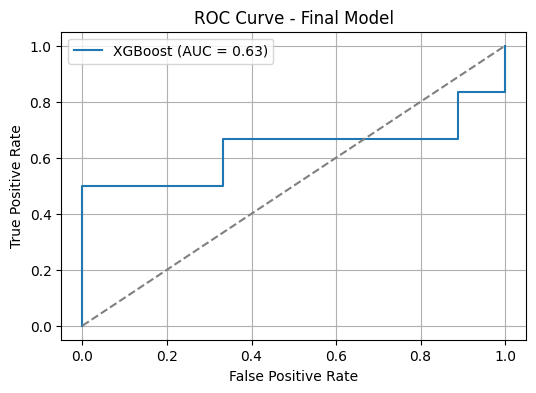

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='XGBoost (AUC = %.2f)' % roc_auc_score(y_test, y_test_proba))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Final Model')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import optuna.visualization as vis

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)


In [ ]:
vis.plot_parallel_coordinate(study)


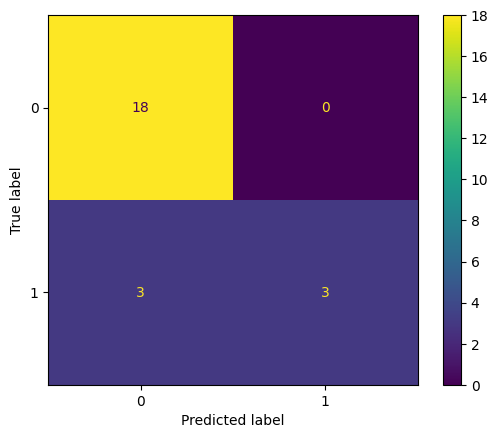

In [ ]:
#summary
#Accuracy, AUC, classification report on the test set
#Confusion matrix to show how well it predicts each class

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


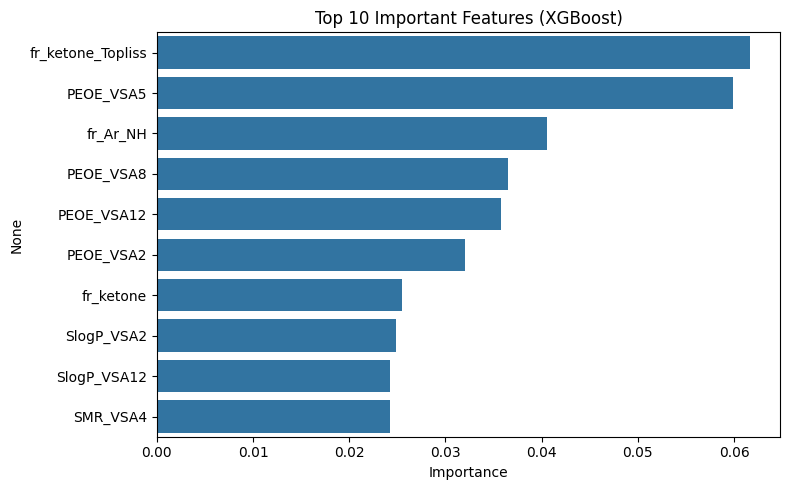

In [ ]:
#High feature importance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dataframe of features and their importances
feature_names = X.columns
importances = final_model.feature_importances_
top_features = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Important Features (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:

test_df = pd.read_csv("DIA_testset_RDKit_descriptors.csv")

#Drop 'Label' if it exists and any non-numeric columns like 'SMILES'
columns_to_drop = ["Label", "SMILES"]
for col in columns_to_drop:
    if col in test_df.columns:
        test_df = test_df.drop(columns=[col])

test_scaled = scaler.transform(test_df)
test_probs = final_model.predict_proba(test_scaled)[:, 1]
predictions_df = pd.DataFrame({
    "Molecule_Index": test_df.index,
    "Predicted_Probability": test_probs
})

predictions_df.to_csv("xgboost_predictions_unlabeled.csv", index=False)

predictions_df.head()



,Molecule_Index,Predicted_Probability
0,0,0.004898
1,1,0.001664
2,2,0.007280
3,3,0.950409
4,4,0.461987


In [ ]:
predictions_df.head(10)


,Molecule_Index,Predicted_Probability
0,0,0.004898
1,1,0.001664
2,2,0.007280
3,3,0.950409
4,4,0.461987
5,5,0.056265
6,6,0.990947
7,7,0.032802
8,8,0.054338
9,9,0.936811


In [ ]:
import joblib
from google.colab import files

# model and scaler
joblib.dump(final_model, "xgboost_final_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# Download
files.download("xgboost_final_model.pkl")
files.download("scaler.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>